In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/rice-diseases-image-dataset/labelledrice/Labelled"))

# Any results you write to the current directory are saved as output.

['Hispa', 'LeafBlast', 'Healthy', 'BrownSpot']


In [2]:
#import required libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms,models
import helper
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [3]:
#directories
directory="../input/rice-diseases-image-dataset/labelledrice/Labelled"

In [4]:
#check if cuda is avaliable
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
#transforms
train_transforms=transforms.Compose([ transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                   
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])
valid_transforms=transforms.Compose([transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [6]:
#load data
image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(directory,transform=train_transforms)
image_datasets['valid']=datasets.ImageFolder(directory,transform=valid_transforms)

#split dataset
num_workers=0
batch_size=128
valid_size=0.1


length_train=len(image_datasets['train'])
indices=list(range(length_train))
split = int(np.floor(valid_size * length_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

#prepare data loaders


train_loader=torch.utils.data.DataLoader(image_datasets["train"],batch_size=batch_size,sampler=train_sampler,shuffle=False)
valid_loader=torch.utils.data.DataLoader(image_datasets["valid"],batch_size=8,sampler=valid_sampler,shuffle=False)



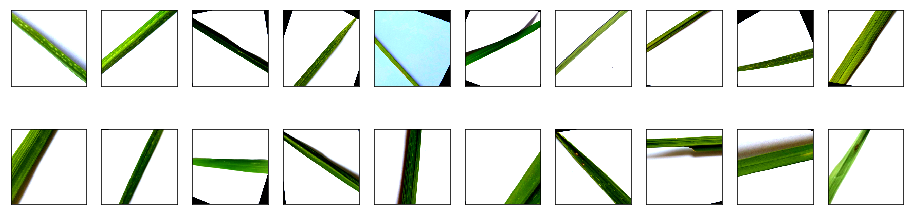

In [7]:
#view images
def show_images(img):
    img=img/2 + 0.5
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
#get one batch
dataiter =iter(train_loader)
images,labels=dataiter.next()


fig = plt.figure(figsize=(16, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    show_images(images[idx])

In [8]:
#build model
#retrained model
model=models.vgg19(pretrained=True)
for params in model.parameters():
    #freeze
    params.requre_grad=True

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 43.2MB/s] 


In [9]:
model.classifier[6].out_features=4
model.classifier[6]

Linear(in_features=4096, out_features=4, bias=True)

In [10]:
#classifier
#use only infeatures and classe


def forward(model,x):
    x=model(x)
    return x


In [11]:
#optimizer,criterion & scheduler
optimizer=torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=8,gamma=0.1)

In [12]:
#move model to GPU
if train_on_gpu:
    model=model.cuda()
#train model
epochs=20
losses=[]
valid_loss_min=np.Inf
for e in range(epochs):
    
    
    #train phase
    train_loss=0
    for ii ,(images,labels) in enumerate(train_loader):
        #clear gradients
        optimizer.zero_grad()
        #move images awith torch.set_grad_enabled(False):nd labels to gpu
        if train_on_gpu:
            images=images.cuda()
            labels=labels.cuda()
        output_t=model(images)
        loss_t=criterion(output_t,labels)
        loss_t.backward()
        train_loss+=loss_t.item()
        optimizer.step()
    
        
    else:
        #validation phase  
        valid_loss=0
        accuracy=0
        model.eval()    
        with torch.set_grad_enabled(False):
            
            for ii,(images,labels) in enumerate(valid_loader):
                if train_on_gpu:
                    images=images.cuda()
                    labels=labels.cuda()
                output_v=model(images)
                loss_v=criterion(output_v,labels)
                valid_loss+=loss_v.item()
           
    print(f"Epochs:{e+1}/{epochs}...",
               f"trainloss: {train_loss/len(train_loader):.3f}...",
                f"validloss: {valid_loss/len(valid_loader):.3f}..."
               )
        
         
       #save model when validation loss has decreased
    if valid_loss/len(valid_loader)<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss/len(valid_loader)))
        torch.save(model,'classifier.pth')
        valid_loss_min=valid_loss/len(valid_loader)
    
    model.train()    
        

Epochs:1/20... trainloss: 2.822... validloss: 2.839...
Validation loss decreased (inf --> 2.839083).  Saving model ...
Epochs:2/20... trainloss: 1.254... validloss: 2.357...
Validation loss decreased (2.839083 --> 2.357145).  Saving model ...
Epochs:3/20... trainloss: 1.177... validloss: 1.981...
Validation loss decreased (2.357145 --> 1.980860).  Saving model ...
Epochs:4/20... trainloss: 1.074... validloss: 2.131...
Epochs:5/20... trainloss: 1.027... validloss: 1.686...
Validation loss decreased (1.980860 --> 1.686095).  Saving model ...
Epochs:6/20... trainloss: 0.971... validloss: 2.093...
Epochs:7/20... trainloss: 0.920... validloss: 1.771...
Epochs:8/20... trainloss: 0.876... validloss: 1.374...
Validation loss decreased (1.686095 --> 1.373589).  Saving model ...
Epochs:9/20... trainloss: 0.837... validloss: 2.063...
Epochs:10/20... trainloss: 0.812... validloss: 1.479...
Epochs:11/20... trainloss: 0.817... validloss: 1.456...
Epochs:12/20... trainloss: 0.789... validloss: 1.288.

In [13]:
def test(loader, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        train_on_gpu = torch.cuda.is_available()
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(valid_loader, model, criterion)

Test Loss: 1.030438


Test Accuracy: 61% (206/335)
